<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/Valentines2009_comparewelch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and unzip the GCP data

In [1]:
# See https://global-mind.org/valentines.09.html for a description of the event
#grab the data - uncomment as needed

! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-14.csv.gz
#! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-15.csv.gz #control1
#! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-13.csv.gz #control2

--2023-09-14 13:27:44--  https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-14.csv.gz
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5110222 (4.9M) [application/x-gzip]
Saving to: ‘eggsummary/2009/basketdata-2009-02-14.csv.gz’

eggsummary/2009/bas 100%[===================>]   4.87M   125KB/s    in 40s     

2023-09-14 13:28:24 (125 KB/s) - ‘eggsummary/2009/basketdata-2009-02-14.csv.gz’ saved [5110222/5110222]

FINISHED --2023-09-14 13:28:24--
Total wall clock time: 40s
Downloaded: 1 files, 4.9M in 40s (125 KB/s)


In [2]:
#unzip the data - uncomment as needed
!gunzip eggsummary/2009/basketdata-2009-02-14.csv.gz
#!gunzip eggsummary/2009/basketdata-2009-02-15.csv.gz
#!gunzip eggsummary/2009/basketdata-2009-02-13.csv.gz

In [3]:
!ls eggsummary/2009

basketdata-2009-02-14.csv


In [4]:
#sanity check the download
!head eggsummary/2009/basketdata-2009-02-14.csv

10,1,10,"Samples per record"
10,2,10,"Seconds per record"
10,3,30,"Records per packet"
10,4,200,"Trial size"
11,1,61,"Eggs reporting"
11,2,1234569600,"Start time",2009-02-14 00:00:00
11,3,1234655999,"End time",2009-02-14 23:59:59
11,4,86400,"Seconds of data"
12,"gmtime",,1,28,37,102,103,105,110,111,112,116,118,119,142,226,228,231,237,1000,1022,1025,1051,1066,1070,1082,1092,1101,1223,2000,2001,2002,2006,2027,2028,2041,2042,2047,2049,2052,2060,2064,2069,2073,2080,2083,2084,2088,2091,2094,2097,2120,2173,2178,2220,2221,2222,2225,2230,2234,2235,2236,3043
13,1234569600,,111,103,100,105,90,96,95,85,104,104,104,102,94,89,92,103,108,101,105,90,108,112,109,94,88,92,102,88,88,97,111,96,103,95,104,100,109,95,106,104,87,102,106,102,115,100,111,100,103,104,116,100,107,99,113,,104,,103,93,90


Ingest the data and compute the $Z^2 - 1$ statistic for each second

In [1]:
#read in all the data

import pandas
eggdata_test = pandas.read_csv("eggsummary/2009/basketdata-2009-02-14.csv", skiprows=8)
#eggdata_control1 = pandas.read_csv("eggsummary/2009/basketdata-2009-02-15.csv", skiprows=8)
#eggdata_control2 = pandas.read_csv("eggsummary/2009/basketdata-2009-02-13.csv", skiprows=8)

In [2]:
import numpy as np
import scipy


def get_chisquareminus1(eggdata):
  egg_values = np.array(eggdata.iloc[:, 3:])
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  print("Average number of RNGs reporting:", np.mean(num_nonnan_eggs))
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs

#get the chisquare minus stat for the test and controls
csm1_test, _ = get_chisquareminus1(eggdata_test)
#csm1_control1, _ = get_chisquareminus1(eggdata_control1)
#csm1_control2, _ = get_chisquareminus1(eggdata_control2)

Average number of RNGs reporting: 58.3374537037037


In [8]:
def get_normalized_power_spectrum(signal):
  #Note: the reason I'm not using scipy's periodogram function is that
  # for real inputs it doubles the power associated with the frequencies
  # that are paired (e.g. https://github.com/scipy/scipy/blob/686422c4f0a71be1b4258309590fd3e9de102e18/scipy/signal/_spectral_py.py#L1901)
  # but this means that the periodogram for a uniform distribution would not be
  # uniform. I'm doing it this way because that is expected to produce a
  # uniform distribution for random noise.
  ps = np.square(np.abs(scipy.fft.rfft(signal)))
  #normalize to sum to 1
  return ps/np.sum(ps)


def get_normalized_power_spectrum_welch(signal, nperseg_division):
  nperseg = int(len(signal)/nperseg_division)
  freqs, ps = scipy.signal.welch(
    signal, nperseg=nperseg, window='boxcar', detrend=False)
  #due to the symmetry property of the fourier transform for real-valued signals,
  # certain frequencies in the power spectrum
  # for real inputs have their power doubled. But we are interested in how the power
  # spectrum differs from a uniform power spectrum, so we need to undo that
  # doubling. Reference: https://github.com/scipy/scipy/blob/686422c4f0a71be1b4258309590fd3e9de102e18/scipy/signal/_spectral_py.py#L1900
  if nperseg%2: #if nperseg is odd
    ps[1:] /= 2
  else:
    ps[1:-1] /= 2
  return freqs, ps/np.sum(ps)


def get_spectrogram(signal, nperseg_division):
  #once again, I am returning 'magnitude' rather than the power spectrum
  # because I don't want the doubling of power to be applied for paired
  # frequencies.
  freqs, time, Sxx = scipy.signal.spectrogram(
      signal, window='boxcar', #'boxcar' i.e. no whitening is appropriate for raw noise
      nperseg=int(len(signal)/nperseg_division),
      detrend=False,
      mode='magnitude')
  return freqs, time, Sxx

Distribution looks very similar for welch smoothed vs. original power spectrum

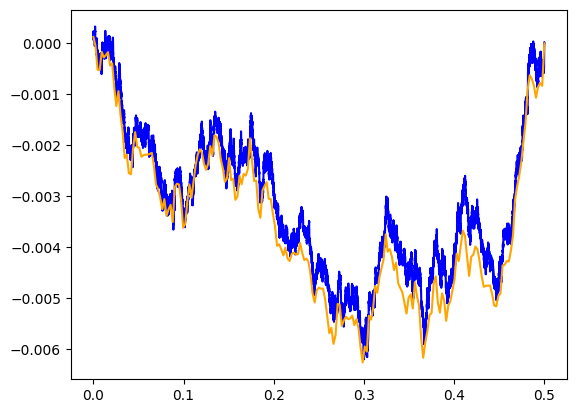

In [11]:
from matplotlib import pyplot as plt
#compare plot of power spectrum on full signal to welch's method

nps_fullsignal = get_normalized_power_spectrum(csm1_test)
freqs = np.fft.rfftfreq(len(csm1_test), 1) #get the frequencies
freqs_welch, nps_fullsignal_welch = get_normalized_power_spectrum_welch(csm1_test, 200)

plt.plot(freqs, np.cumsum(nps_fullsignal - 1.0/len(nps_fullsignal)), color="blue")
plt.plot(freqs_welch, np.cumsum(nps_fullsignal_welch - 1.0/len(nps_fullsignal_welch)), color="orange")
plt.show()

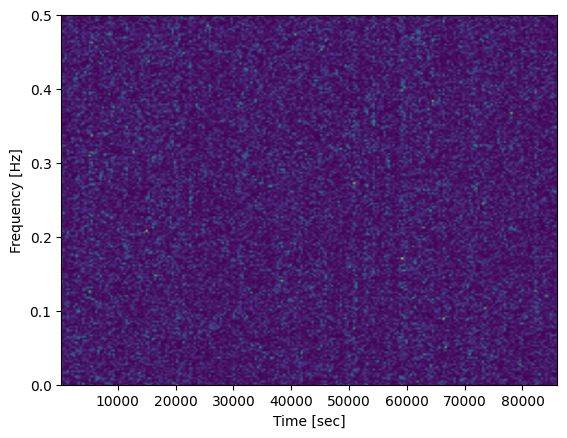

In [13]:
#Also display the spectrogram for what it's worth
from matplotlib import pyplot as plt
%matplotlib inline

freqs, time, Sxx = get_spectrogram(csm1_test, 200)

#square Sxx to go from magnitude to something proportional to power
plt.pcolormesh(time, freqs, np.square(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()